In [4]:
import sys
# !{sys.executable} -m pip install pyvis
# !{sys.executable} -m pip install datashader
!{sys.executable} -m pip install py3plex


Processing c:\users\kgulp\appdata\local\pip\cache\wheels\89\4e\40\e748d70e2848531acfe0a23071ae48cff4ee69bb3522ee0fe2\py3plex-0.94-py3-none-any.whl
  Using cached bitarray-1.2.1.tar.gz (48 kB)
  Running setup.py clean for bitarray
Failed to build bitarray
  Attempting uninstall: bitarray
    Found existing installation: bitarray 1.6.1
    Uninstalling bitarray-1.6.1:
      Successfully uninstalled bitarray-1.6.1
    Running setup.py install for bitarray: started
    Running setup.py install for bitarray: finished with status 'error'
  Rolling back uninstall of bitarray
  Moving to c:\users\kgulp\anaconda3\lib\site-packages\bitarray-1.6.1.dist-info\
   from C:\Users\KGulp\anaconda3\Lib\site-packages\~itarray-1.6.1.dist-info
  Moving to c:\users\kgulp\anaconda3\lib\site-packages\bitarray\
   from C:\Users\KGulp\anaconda3\Lib\site-packages\~itarray


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\KGulp\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\KGulp\\AppData\\Local\\Temp\\pip-install-clvp8hro\\bitarray\\setup.py'"'"'; __file__='"'"'C:\\Users\\KGulp\\AppData\\Local\\Temp\\pip-install-clvp8hro\\bitarray\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\KGulp\AppData\Local\Temp\pip-wheel-8qiwuvwf'
       cwd: C:\Users\KGulp\AppData\Local\Temp\pip-install-clvp8hro\bitarray\
  Complete output (13 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\bitarray
  copying bitarray\test_bitarray.py -> build\lib.win-amd64-3.8\bitarray
  copying bitarray\test_util.py -> build\lib.win-amd64-3.8\bitarray
  copying bitarray\util

In [3]:
from pyvis.network import Network
import networkx as nx
import pandas as pd
import math
import numpy as np


import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
# from py3plex.core import multinet

from itertools import chain

In [47]:
net = Network(notebook=True)
df = pd.read_csv('Data/tab_n.csv')


In [48]:
x = sum(df['n'])

In [49]:
round(x / 10)

86100

In [43]:
nodes = pd.concat([df['source'],df['destination']]).unique()

print(len(nodes))

pd.DataFrame({'Nodes': nodes}).to_csv('gephi_nodes.csv')

edges = df[['source', 'destination']]

edges.to_csv('gephi_edges.csv')

79422


In [68]:
G = nx.from_pandas_edgelist(df, 'source', 'destination', create_using=nx.DiGraph())

In [69]:
nodes = pd.DataFrame()
temp_df = pd.concat([df['source'],df['destination']])

temp_df = pd.factorize(df.source)[0] + 1

length = np.array_split(temp_df, 2)

df_ = pd.DataFrame()
df_['source'] = length[0]
df_['destination'] = length[1]


nodes['name'] = pd.unique(df_[['source', 'destination']].values.ravel('K'))

In [70]:
circular  = circular_layout(nodes, uniform=False)
randomloc = random_layout(nodes)
randomloc.tail()


,name,x,y
76863,76864,0.043105,0.091400
76864,76865,0.745748,0.422766
76865,76866,0.104676,0.288981
76866,76867,0.166508,0.523104
76867,76868,0.677717,0.935504


Random layout,Circular layout

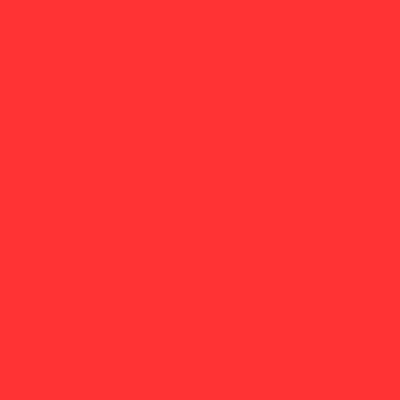
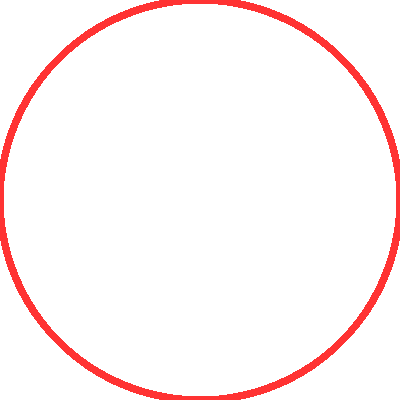

In [71]:
cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

tf.Images(nodesplot(randomloc,"Random layout"),
          nodesplot(circular, "Circular layout"))

In [73]:
df_ = df_.rename(columns={"destination": "target"})

In [75]:
print(df_)

%time 

df_ = df_[['source', 'target']]

forcedirected = forceatlas2_layout(nodes, df_)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

        source  target
0            1   36643
1            2   36688
2            3   35201
3            4   37778
4            5   37603
...        ...     ...
245037   36826   76770
245038   34668   76802
245039   36776   76645
245040   34834   76697
245041   37620   76862

[245042 rows x 2 columns]
Wall time: 0 ns


KeyboardInterrupt: 

In [ ]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

In [ ]:
cd = circular
fd = forcedirected

# cd_d = graphplot(cd, connect_edges(cd,df), "Circular layout")
# fd_d = graphplot(fd, connect_edges(fd,df), "Force-directed") 
# cd_b = graphplot(randomloc, hammer_bundle(randomloc,df), "Circular layout, bundled")
fd_b = graphplot(fd, hammer_bundle(fd,df), "Force-directed, bundled") 

tf.Images(fd_d).cols(2)

In [38]:
graphs = []
types = ['huishouden', 'familie', 'buren', 'werkschool']
for type in types:
    df = pd.read_csv(f'Data/NW_data/{type}_nw.csv')
    G = nx.from_pandas_edgelist(df, 'source_id', 'destination_id',['source', 'destination'] ,create_using=nx.DiGraph())
    
    graphs.append(G)

In [25]:
def get_type_node(G, id):
    return list(G[id].values())[0]['source']


In [52]:
l_n_edges = []
l_n_nodes = []
l_average_in_degees = []
l_type_max_in_degree = []
l_average_out_degrees = []
l_type_max_out_degree = []
l_average_cluster_coefficient = []
l_type_highest_cluster_coefficient = []
l_reciprocity = []

for G in graphs:
    
    
    # Number of edges
    n_edges = G.number_of_edges()
    l_n_edges.append(n_edges)
    
    # Number of nodes
    n_nodes = G.number_of_nodes() 
    l_n_nodes.append(n_nodes)
    
    # Calculate degree
    G.degree()
    degrees = {i[1]:i[0] for i in G.degree()}
    l_degrees = [ i[1] for i in G.degree()]

    average_degree = np.mean(l_degrees)

    # Calculate indegree
    G.in_degree()
    in_degrees = {i[1]:i[0] for i in G.in_degree()}
    l_in_degrees = [ i[1] for i in G.in_degree()]


    max_in_degree = max(in_degrees.keys())
    id_max_in_degree = in_degrees[max(in_degrees.keys())]
    type_max_in_degree = get_type_node(G,id_max_in_degree)
    l_type_max_in_degree.append(type_max_in_degree)
    
    average_in_degree = np.mean(l_in_degrees)
    l_average_in_degees.append(average_in_degree)

    # Calculate outdegree
    G.out_degree()
    out_degrees = {i[1]:i[0] for i in G.out_degree()}
    l_out_degrees = [ i[1] for i in G.out_degree()]

    max_out_degree = max(out_degrees.keys())
    id_max_out_degree = out_degrees[max(out_degrees.keys())]
    type_max_out_degree = list(G[id_max_out_degree].values())[0]['source']
    l_type_max_out_degree.append(type_max_out_degree)
    
    average_out_degree = np.mean(l_out_degrees)
    l_average_out_degrees.append(average_out_degree)

    # Density
    density = nx.classes.function.density(G)
    
    # Cluster coefficient
    cluster_coefficient = nx.clustering(G)
    
    highest_cluster_coefficient = max(cluster_coefficient.values())

    id_highest_cluster_coefficient = (list(cluster_coefficient.keys())
                                   [list(cluster_coefficient.values()).index(highest_cluster_coefficient)])  # Prints george

    type_highest_cluster_coefficient = get_type_node(G,id_highest_cluster_coefficient)
    l_type_highest_cluster_coefficient.append(type_highest_cluster_coefficient)

    average_cluster_coefficient = np.mean(list(cluster_coefficient.values()))
    l_average_cluster_coefficient.append(average_cluster_coefficient)
    
    # In degree centrality
    in_degree_centrality  = nx.in_degree_centrality(G)


    # Out degree centrality
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # Reciprocity
    overall_reciprocity = nx.overall_reciprocity(G)
    l_reciprocity.append(overall_reciprocity)

    # Transitivity
    overall_transicity = nx.transitivity(G)
    

In [53]:
total_nodes = [86100] * 4

df_stats = pd.DataFrame({'edges' : l_n_edges,'nodes' : total_nodes,'connected_nodes' : l_n_nodes, 'avg indegree':l_average_in_degees, 'max in degree': l_type_max_in_degree, 'avg out degree':l_average_out_degrees,'max out degree':l_type_max_out_degree,'avg clustercoefficient': l_average_cluster_coefficient, 'max cluster coefficient':l_type_highest_cluster_coefficient, 'reciprocity' : l_reciprocity}, index = types)

In [54]:
df_stats

,edges,nodes,connected_nodes,avg indegree,max in degree,avg out degree,max out degree,avg clustercoefficient,max cluster coefficient,reciprocity
huishouden,141572,86100,50459,2.805684,"57_1534, [0,20), Overig, 1",2.805684,"57_1534, [0,20), Overig, 1",0.000191,"44_664, [50,60), Overig, 3",1.000000
familie,136988,86100,56482,2.425339,"57_2460, [0,20), Overig, 1",2.425339,"57_2460, [0,20), Overig, 1",0.000251,"128_132, [50,60), Autochtoon, 3",0.999898
buren,437425,86100,85508,5.115603,"68_614, [20,30), Overig, 3",5.115603,"68_484, [20,30), Overig, 3",0.000736,"127_207, [50,60), Autochtoon, 2",0.009099
werkschool,587055,86100,79422,7.391592,"52_133, [0,20), Overig, 2",7.391592,"58_99, [0,20), Overig, 2",0.000219,"34_221, [60,70), Overig, 2",0.000371


0.0004558246462404376

In [12]:
G)

In [13]:
overall_reciprocity

1.0

In [363]:
df = pd.read_csv('Data/NW_data/huishouden_nw_test.csv')
G = nx.from_pandas_edgelist(df, 'source_id', 'destination_id',['source', 'destination'] ,create_using=nx.DiGraph())

In [364]:
nx.overall_reciprocity(G)

1.0

In [365]:
df

,Unnamed: 0,source_id,destination_id,source,destination,layer
0,0,7_140,6_4590,"7_140, [0,20), Autochtoon, 2","6_4590, [0,20), Autochtoon, 1",1
1,1,6_4590,7_140,"6_4590, [0,20), Autochtoon, 1","7_140, [0,20), Autochtoon, 2",1
2,2,7_690,6_4985,"7_690, [0,20), Autochtoon, 2","6_4985, [0,20), Autochtoon, 1",1
3,3,6_4985,7_690,"6_4985, [0,20), Autochtoon, 1","7_690, [0,20), Autochtoon, 2",1
4,4,7_1319,6_11890,"7_1319, [0,20), Autochtoon, 2","6_11890, [0,20), Autochtoon, 1",1
...,...,...,...,...,...,...
417,417,6_18550,7_1004,"6_18550, [0,20), Autochtoon, 1","7_1004, [0,20), Autochtoon, 2",1
418,418,7_1632,6_17306,"7_1632, [0,20), Autochtoon, 2","6_17306, [0,20), Autochtoon, 1",1
419,419,6_17306,7_1632,"6_17306, [0,20), Autochtoon, 1","7_1632, [0,20), Autochtoon, 2",1
420,420,7_1491,6_12638,"7_1491, [0,20), Autochtoon, 2","6_12638, [0,20), Autochtoon, 1",1


In [367]:
df = df[df.duplicated(subset=['source_id','destination_id'], keep=False)]

df

,Unnamed: 0,source_id,destination_id,source,destination,layer


In [344]:
df1= pd.DataFrame({
        'Grade': ['A','C','B','Ex']})
df2 = pd.DataFrame({
        'Grade': ['A','B','F','X', 'D', 'F', 'C','A']})

df1


,Grade
0,A
1,C
2,B
3,Ex


In [212]:
df3=pd.merge(df1,df2, how='inner')
df3

,Grade
0,A
1,A
2,C
3,B
